In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR


## 確認裝置

In [32]:
# 1. 裝置設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")

使用裝置：cuda:0


## 下載資料集

In [33]:
# 2. 資料前處理與載入
'''
# 訓練集 Data Augmentation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 顏色增強
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''
'''
# 測試集只正規化
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''



transform = transforms.Compose([
    transforms.ToTensor(),  # 直接將像素從 [0,255] => [0,1]
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)


In [35]:

class CNN2(nn.Module):



    def __init__(self, num_classes=100):
        super().__init__()
        act = nn.GELU()  # 或改成 nn.GELU()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            act,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)                          # 32x32 -> 16x16
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 16x16 -> 16x16
            nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)                          # 16x16 -> 8x8
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            act,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)  # 8 -> 4
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            act,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)  # 8 -> 4
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            act,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)  # 8 -> 4
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # 8x8 -> 1x1
        #self.fc1 = nn.Linear(64, num_classes)
        self.dropout=nn.Dropout(0.4)
        self.fc1 = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.block1(x)
        x=self.dropout(x)   # (B,64,16,16)
        x = self.block2(x)
        #x=self.dropout(x)  # (B,128,8,8)
        x=self.block3(x)
        #x=self.dropout(x)
        x=self.block4(x)
        #x=self.dropout(x)
        #x=self.block5(x)
        #x=self.dropout(x)
        x = self.gap(x)      # (B,256,1,1)
        x = x.view(x.size(0), -1)  # (B,256)

        x = self.fc1(x)      # (B,num_classes)
        return x

model2 = CNN2().to(device)
print(model2)

# 4. 損失與優化器
criterion = nn.CrossEntropyLoss()  # 直接接收整數標籤
optimizer = optim.Adam(model2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

CNN2(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

Epoch 1/80 — Train Loss: 3.4451, Train Acc: 0.1788 — Val Loss: 3.3060, Val Acc: 0.2092
Epoch 2/80 — Train Loss: 2.6739, Train Acc: 0.3181 — Val Loss: 3.3227, Val Acc: 0.2337
Epoch 3/80 — Train Loss: 2.3603, Train Acc: 0.3841 — Val Loss: 2.4176, Val Acc: 0.3731
Epoch 4/80 — Train Loss: 2.1632, Train Acc: 0.4272 — Val Loss: 2.3186, Val Acc: 0.3988
Epoch 5/80 — Train Loss: 2.0139, Train Acc: 0.4603 — Val Loss: 2.3742, Val Acc: 0.3977
Epoch 6/80 — Train Loss: 1.8702, Train Acc: 0.4940 — Val Loss: 2.1002, Val Acc: 0.4449
Epoch 7/80 — Train Loss: 1.7669, Train Acc: 0.5136 — Val Loss: 2.1648, Val Acc: 0.4427
Epoch 8/80 — Train Loss: 1.6815, Train Acc: 0.5401 — Val Loss: 2.0221, Val Acc: 0.4790
Epoch 9/80 — Train Loss: 1.6059, Train Acc: 0.5544 — Val Loss: 2.0249, Val Acc: 0.4733
Epoch 10/80 — Train Loss: 1.5290, Train Acc: 0.5729 — Val Loss: 1.7537, Val Acc: 0.5296
Epoch 11/80 — Train Loss: 1.4455, Train Acc: 0.5929 — Val Loss: 1.7609, Val Acc: 0.5285
Epoch 12/80 — Train Loss: 1.3895, Train A

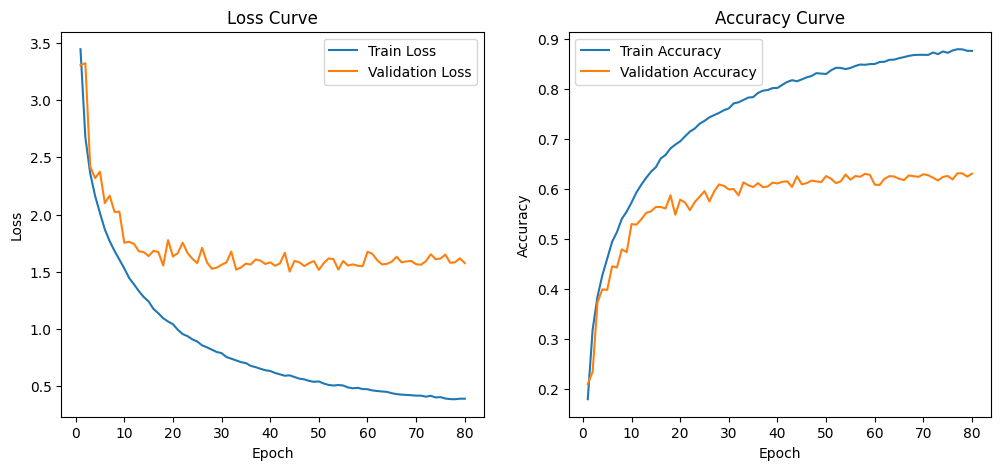

In [36]:
import matplotlib.pyplot as plt

num_epochs = 80

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # ====== 訓練 ======
    model2.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ====== 驗證 ======
    model2.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(testloader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step()
# ====== 畫 Loss 曲線 ======
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# ====== 畫 Accuracy 曲線 ======
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
